In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.colors as mcolors
import json
import seaborn as sns
import traceback

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

corr_data_path = 'task_level_correlations'
files = [fn for fn in glob.glob(f'{corr_data_path}/*.json',recursive=True)]

jsons =  {}
for file in files:
    f = open(file)
    try:
        jsons[file] = json.load(f)
    except Exception as e:
        traceback.print_exc()

In [5]:
data_path = 'data_task'
files = [fn for fn in glob.glob(f'{data_path}/**/*.csv',recursive=True)]

dfs =  {}
for file in files:
    print(file)
    dfs[file] = pd.read_csv(file)

data_task/superglue_filtered.csv
data_task/glue_filtered.csv
data_task/glue.csv
data_task/xtrem_filtered.csv
data_task/superglue.csv
data_task/xtrem.csv
data_task/gem_filtered.csv
data_task/gem.csv


task_level_correlations/gem_filtered.json


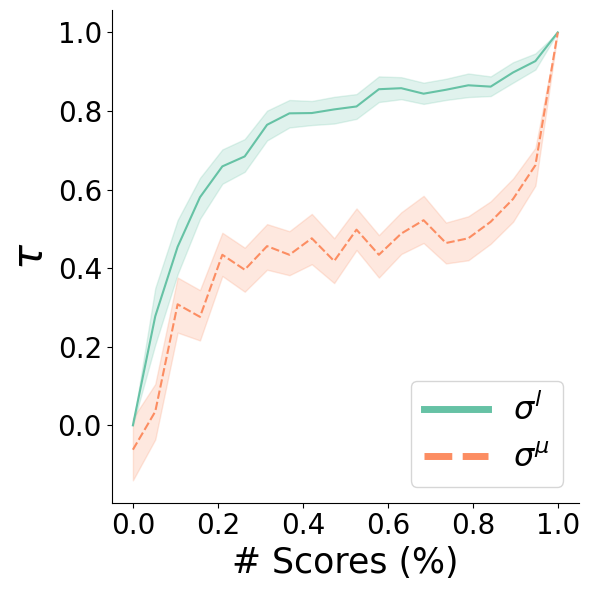

task_level_correlations/glue_filtered.json


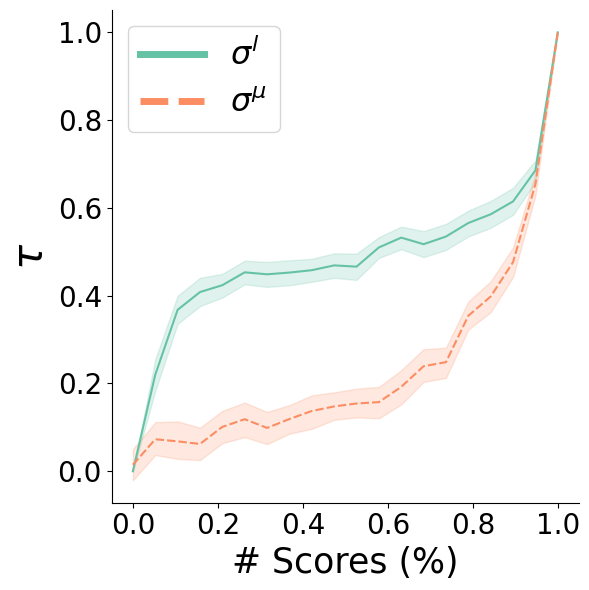

task_level_correlations/xtrem_filtered.json


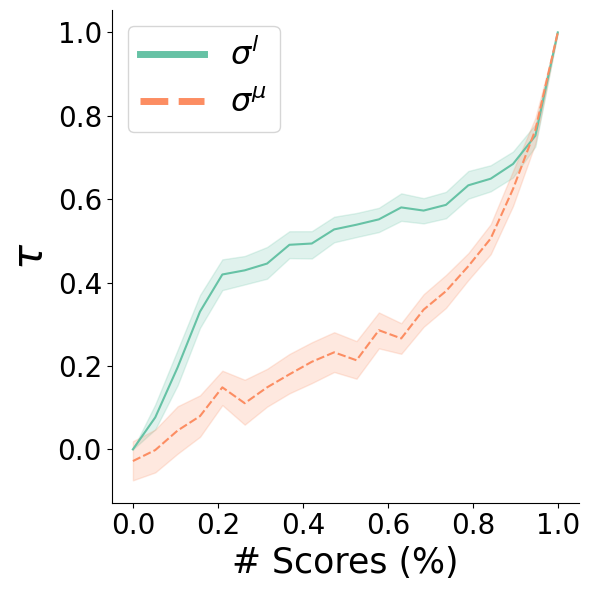

task_level_correlations/superglue_filtered.json


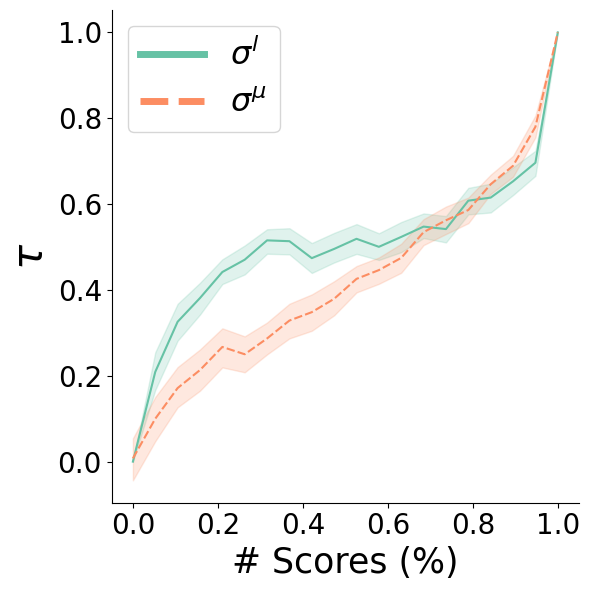

In [20]:
import matplotlib as mpl 
mpl.rcParams['axes.spines.right'] = False 
mpl.rcParams['axes.spines.top'] = False

for file in jsons:
    if "samples" in jsons[file] and jsons[file]["samples"]>0:
        try:
            print(file)
            dfs_to_plot = {}
            for t in jsons[file]['results']:
                dfs_to_plot[t] = {}
                for r in jsons[file]['results'][t]:
                    dfs_to_plot[t][r] = pd.DataFrame(jsons[file]['results'][t][r])
            # draw each removal in a horizontal subplot
            for t in dfs_to_plot:
                df_to_plot = dfs_to_plot[t][list(dfs_to_plot[t].keys())[0]]
                df_to_plot['eta'] = 1-np.array(jsons[file]['etas']*jsons[file]["samples"])
                for k in df_to_plot:
                    if k!="eta":
                        df_to_plot[k] = df_to_plot[k].map(lambda x: x["correlation"])
                df_to_plot = df_to_plot.fillna(0)
                sns.set_palette("Set2")
                fig,ax = plt.subplots(figsize=(6,6))
                ax = sns.lineplot(x="eta", y="value",style='variable',hue='variable',data=pd.melt(df_to_plot, ['eta']))
                plt.yticks(fontsize=20) #hue="losses",
                plt.xticks(fontsize=20) #hue="losses",
                plt.ylabel('$\\tau$',fontsize=30)
                plt.xlabel('# Scores (%)',fontsize=25)
                plt.tight_layout()
                L=plt.legend(fontsize=23)
                for line in L.get_lines():
                    line.set_linewidth(5.0)
                L.get_texts()[0].set_text('${\sigma}^{l}$')
                L.get_texts()[1].set_text('${\sigma}^\mu$')
                # set frametone to false

                plt.savefig(f'task_level_figures/{file.split(os.path.sep)[-1]}_{t}.png',bbox_inches='tight')
                plt.show()
        except Exception as e: 
            traceback.print_exc()



In [7]:
# aggreement analysis
import scipy.stats as stats
aggreements={}
for file in jsons:
    aggreements[file] = {"mean-one":[]} # lists all aggreements
    j = jsons[file]
    for t in j["results"]:
        for r in j["results"][t]:
            for i in range(len(j["results"][t][r]["one_level"])):
                if i!=len(j["results"][t][r]["one_level"])-1:
                    aggreements[file]["mean-one"].append(stats.kendalltau(j["results"][t][r]["mean"][i]["ranking"],j["results"][t][r]["one_level"][i]["ranking"])[0])
    for k in aggreements[file]:
        aggreements[file][k] = [0 if np.isnan(x) else x for x in aggreements[file][k]]

In [8]:
# generate mean and std aggreement globally for all datasets
global_aggreements = {}
for file in aggreements:
    global_aggreements[file] = {"mean-one":[]}
    for k in aggreements[file]:
        global_aggreements[file][k].extend(aggreements[file][k])

# print mean and std aggreement globally for all datasets
for file in global_aggreements:
    print(file + ": {:.2f} +- {:.2f}".format(np.mean(global_aggreements[file]["mean-one"]),np.std(global_aggreements[file]["mean-one"])))

task_level_correlations/gem_filtered.json: 0.36 +- 0.36
task_level_correlations/glue_filtered.json: 0.17 +- 0.24
task_level_correlations/xtrem_filtered.json: 0.26 +- 0.26
task_level_correlations/superglue_filtered.json: 0.33 +- 0.27


In [17]:
# ratio of aggreement of the top k systems
k = 0 # best system
# k = 2 # third best system
counts = {}
for file in jsons:
    counts[file] = {"mean-one":0} # number of times the best system is the same for each aggregation
    c_double = 0
    total = 0 
    j = jsons[file]
    for t in j["results"]:
        for r in j["results"][t]:
            for i in range(len(j["results"][t][r]["mean"])):
                if i!=len(j["results"][t][r]["mean"])-1:
                    # get the indices of that are equal to k for each aggregation
                    mean_k = [x for x in range(len(j["results"][t][r]["mean"][i]["ranking"])) if j["results"][t][r]["mean"][i]["ranking"][x]==k]
                    one_k = [x for x in range(len(j["results"][t][r]["one_level"][i]["ranking"])) if j["results"][t][r]["one_level"][i]["ranking"][x]==k]
                    if len(mean_k)==0 or len(one_k)==0:
                        c_double+=1
                    else:
                        if set(mean_k)==set(one_k):
                            counts[file]["mean-one"]+=1
                    total+=1

In [18]:
print(k)
print(c_double)
print(counts)
print(total)
for file in counts:
    for t in counts[file]:
        print(file + " : " + str(counts[file][t]/total))

0
215
{'task_level_correlations/gem_filtered.json': {'mean-one': 1034}, 'task_level_correlations/glue_filtered.json': {'mean-one': 193}, 'task_level_correlations/xtrem_filtered.json': {'mean-one': 372}, 'task_level_correlations/superglue_filtered.json': {'mean-one': 400}}
1999
task_level_correlations/gem_filtered.json : 0.5172586293146574
task_level_correlations/glue_filtered.json : 0.09654827413706854
task_level_correlations/xtrem_filtered.json : 0.18609304652326164
task_level_correlations/superglue_filtered.json : 0.2001000500250125
